## Module 6 Homework 

In this homework, we're going to extend Module 5 Homework and learn about streaming with PySpark.

Instead of Kafka, we will use Red Panda, which is a drop-in
replacement for Kafka. 

Ensure you have the following set up (if you had done the previous homework and the module):

- Docker (see [module 1](https://github.com/DataTalksClub/data-engineering-zoomcamp/tree/main/01-docker-terraform))
- PySpark (see [module 5](https://github.com/DataTalksClub/data-engineering-zoomcamp/tree/main/05-batch/setup))

For this homework we will be using the files from Module 5 homework:

- Green 2019-10 data from [here](https://github.com/DataTalksClub/nyc-tlc-data/releases/download/green/green_tripdata_2019-10.csv.gz)



## Start Red Panda

Let's start redpanda in a docker container. 

There's a `docker-compose.yml` file in the homework folder (taken from [here](https://github.com/redpanda-data-blog/2023-python-gsg/blob/main/docker-compose.yml))

Copy this file to your homework directory and run

```bash
docker-compose up
```

(Add `-d` if you want to run in detached mode)

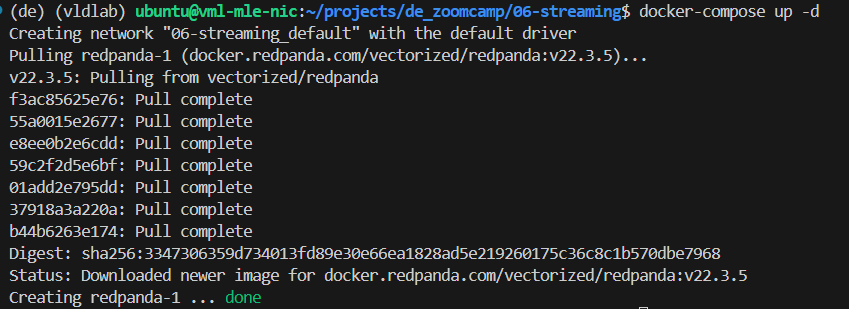

## Question 1: Redpanda version

Now let's find out the version of redpandas. 

For that, check the output of the command `rpk help` _inside the container_. The name of the container is `redpanda-1`.

Find out what you need to execute based on the `help` output.

What's the version, based on the output of the command you executed? (copy the entire version)

In [1]:
!docker-compose exec redpanda-1 rpk help

rpk is the Redpanda CLI & toolbox

Usage:
  rpk [command]

Available Commands:
  acl         Manage ACLs and SASL users
  cloud       Interact with Redpanda cloud
  cluster     Interact with a Redpanda cluster
  container   Manage a local container cluster
  debug       Debug the local Redpanda process
  generate    Generate a configuration template for related services
  group       Describe, list, and delete consumer groups and manage their offsets
  help        Help about any command
  iotune      Measure filesystem performance and create IO configuration file
  plugin      List, download, update, and remove rpk plugins
  redpanda    Interact with a local Redpanda process
  topic       Create, delete, produce to and consume from Redpanda topics
  version     Check the current version
  wasm        Deploy and remove inline WASM engine scripts

Flags:
  -h, --help      Help for rpk
  -v, --verbose   Enable verbose logging (default: false)

Use "rpk [command] --help" for more informati

In [2]:
!docker-compose exec redpanda-1 rpk version

v22.3.5 (rev 28b2443)


## Question 2. Creating a topic

Before we can send data to the redpanda server, we
need to create a topic. We do it also with the `rpk`
command we used previously for figuring out the version of 
redpandas.

Read the output of `help` and based on it, create a topic with name `test-topic` 

What's the output of the command for creating a topic? Include the entire output in your answer.


In [3]:
!docker-compose exec redpanda-1 rpk topic create -h

Create topics.

All topics created with this command will have the same number of partitions,
replication factor, and key/value configs.

For example,

	create -c cleanup.policy=compact -r 3 -p 20 foo bar

will create two topics, foo and bar, each with 20 partitions, 3 replicas, and
the cleanup.policy=compact config option set.

Usage:
  rpk topic create [TOPICS...] [flags]

Flags:
  -d, --dry                        Dry run: validate the topic creation request; do not create topics
  -h, --help                       Help for create
  -p, --partitions int32           Number of partitions to create per topic; -1 defaults to the cluster's default_topic_partitions (default -1)
  -r, --replicas int16             Replication factor (must be odd); -1 defaults to the cluster's default_topic_replications (default -1)
  -c, --topic-config stringArray   key=value; Config parameters (repeatable; e.g. -c cleanup.policy=compact)

Global Flags:
      --brokers strings         Comma-separated list of 

In [4]:
!docker-compose exec redpanda-1 rpk topic create test-topic

TOPIC       STATUS
test-topic  OK


## Question 3. Connecting to the Kafka server

We need to make sure we can connect to the server, so later we can send some data to its topics

First, let's install the kafka connector (up to you if you want to have a separate virtual environment for that)

```bash
pip install kafka-python
```

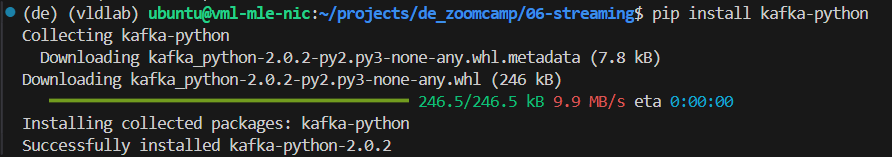

You can start a jupyter notebook in your solution folder or create a script

Let's try to connect to our server:

```python
import json
import time 

from kafka import KafkaProducer

def json_serializer(data):
    return json.dumps(data).encode('utf-8')

server = 'localhost:9092'

producer = KafkaProducer(
    bootstrap_servers=[server],
    value_serializer=json_serializer
)

producer.bootstrap_connected()
```

Provided that you can connect to the server, what's the output of the last command?

In [5]:
import json
import time 

from kafka import KafkaProducer

def json_serializer(data):
    return json.dumps(data).encode('utf-8')

server = 'localhost:9092'

producer = KafkaProducer(
    bootstrap_servers=[server],
    value_serializer=json_serializer
)

producer.bootstrap_connected()

True

## Question 4. Sending data to the stream

Now we're ready to send some test data:

```python
t0 = time.time()

topic_name = 'test-topic'

for i in range(10):
    message = {'number': i}
    producer.send(topic_name, value=message)
    print(f"Sent: {message}")
    time.sleep(0.05)

producer.flush()

t1 = time.time()
print(f'took {(t1 - t0):.2f} seconds')
```

How much time did it take? Where did it spend most of the time?

* Sending the messages
* Flushing
* Both took approximately the same amount of time

(Don't remove `time.sleep` when answering this question)

In [6]:
t0 = time.time()

topic_name = 'test-topic'

for i in range(10):
    message = {'number': i}
    producer.send(topic_name, value=message)
    print(f"Sent: {message}")
    time.sleep(0.05)

producer.flush()

t1 = time.time()
print(f'took {(t1 - t0):.2f} seconds')

Sent: {'number': 0}
Sent: {'number': 1}
Sent: {'number': 2}
Sent: {'number': 3}
Sent: {'number': 4}
Sent: {'number': 5}
Sent: {'number': 6}
Sent: {'number': 7}
Sent: {'number': 8}
Sent: {'number': 9}
took 0.51 seconds


## Reading data with `rpk`

You can see the messages that you send to the topic
with `rpk`:

```bash
rpk topic consume test-topic
```

Run the command above and send the messages one more time to see them

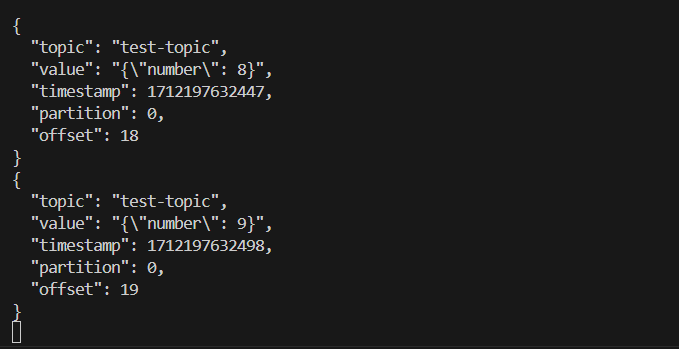

## Sending the taxi data

Now let's send our actual data:

* Read the green csv.gz file
* We will only need these columns:
  * `'lpep_pickup_datetime',`
  * `'lpep_dropoff_datetime',`
  * `'PULocationID',`
  * `'DOLocationID',`
  * `'passenger_count',`
  * `'trip_distance',`
  * `'tip_amount'`

Iterate over the records in the dataframe

```python
for row in df_green.itertuples(index=False):
    row_dict = {col: getattr(row, col) for col in row._fields}
    print(row_dict)
    break

    # TODO implement sending the data here
```

Note: this way of iterating over the records is more efficient compared
to `iterrows`


In [7]:
import pandas as pd

df = pd.read_csv('green_tripdata_2019-10.csv.gz')
cols = ['lpep_pickup_datetime', 'lpep_dropoff_datetime', 'PULocationID', 'DOLocationID', 'passenger_count', 'trip_distance', 'tip_amount']
df_green = df[cols]

df_green.shape

/tmp/ipykernel_230895/884204457.py:3: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('green_tripdata_2019-10.csv.gz')


(476386, 7)

In [8]:
for row in df_green.itertuples(index=False):
    row_dict = {col: getattr(row, col) for col in row._fields}
    producer.send(topic_name, value=row_dict)
    print(f"Sent: {row_dict}")
    #print(row_dict)
    break

producer.flush()

Sent: {'lpep_pickup_datetime': '2019-10-01 00:26:02', 'lpep_dropoff_datetime': '2019-10-01 00:39:58', 'PULocationID': 112, 'DOLocationID': 196, 'passenger_count': 1.0, 'trip_distance': 5.88, 'tip_amount': 0.0}


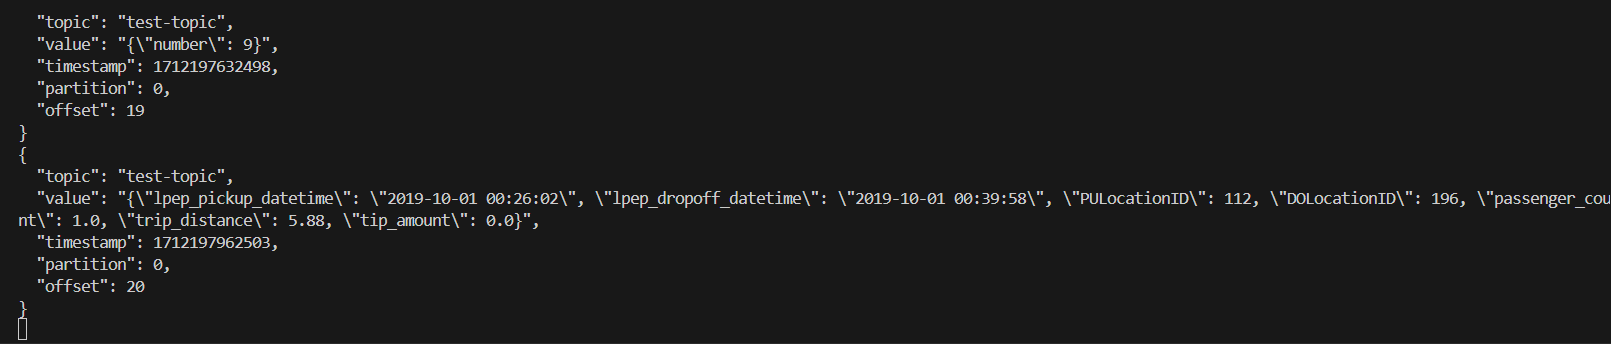

## Question 5: Sending the Trip Data

* Create a topic `green-trips` and send the data there
* How much time in seconds did it take? (You can round it to a whole number)
* Make sure you don't include sleeps in your code

In [9]:
!docker-compose exec redpanda-1 rpk topic create green-trips

TOPIC        STATUS
green-trips  OK


In [10]:
t0 = time.time()

c = 0
topic_name = 'green-trips'

for row in df_green.itertuples(index=False):
    row_dict = {col: getattr(row, col) for col in row._fields}
    producer.send(topic_name, value=row_dict)
    c += 1
    #print(f"Sent: {row_dict}")

producer.flush()

t1 = time.time()

In [11]:
print(f'Sent {c} rows - Elapsed time: {(t1 - t0):.2f} seconds')

Sent 476386 rows - Elapsed time: 56.38 seconds


## Creating the PySpark consumer

Now let's read the data with PySpark. 

Spark needs a library (jar) to be able to connect to Kafka, 
so we need to tell PySpark that it needs to use it:

```python
import pyspark
from pyspark.sql import SparkSession

pyspark_version = pyspark.__version__
kafka_jar_package = f"org.apache.spark:spark-sql-kafka-0-10_2.12:{pyspark_version}"

spark = SparkSession \
    .builder \
    .master("local[*]") \
    .appName("GreenTripsConsumer") \
    .config("spark.jars.packages", kafka_jar_package) \
    .getOrCreate()
```

Now we can connect to the stream:

```python
green_stream = spark \
    .readStream \
    .format("kafka") \
    .option("kafka.bootstrap.servers", "localhost:9092") \
    .option("subscribe", "green-trips") \
    .option("startingOffsets", "earliest") \
    .load()
```

In order to test that we can consume from the stream, 
let's see what will be the first record there. 

In Spark streaming, the stream is represented as a sequence of 
small batches, each batch being a small RDD (or a small dataframe).

So we can execute a function over each mini-batch.
Let's run `take(1)` there to see what do we have in the stream:

```python
def peek(mini_batch, batch_id):
    first_row = mini_batch.take(1)

    if first_row:
        print(first_row[0])

query = green_stream.writeStream.foreachBatch(peek).start()
```

You should see a record like this:

```
Row(key=None, value=bytearray(b'{"lpep_pickup_datetime": "2019-10-01 00:26:02", "lpep_dropoff_datetime": "2019-10-01 00:39:58", "PULocationID": 112, "DOLocationID": 196, "passenger_count": 1.0, "trip_distance": 5.88, "tip_amount": 0.0}'), topic='green-trips', partition=0, offset=0, timestamp=datetime.datetime(2024, 3, 12, 22, 42, 9, 411000), timestampType=0)
```

Now let's stop the query, so it doesn't keep consuming messages
from the stream

```python
query.stop()
```

In [12]:
import pyspark
from pyspark.sql import SparkSession

pyspark_version = pyspark.__version__
kafka_jar_package = f"org.apache.spark:spark-sql-kafka-0-10_2.12:{pyspark_version}"

spark = SparkSession \
    .builder \
    .master("local[*]") \
    .appName("GreenTripsConsumer") \
    .config("spark.jars.packages", kafka_jar_package) \
    .getOrCreate()

24/04/07 03:26:08 WARN Utils: Your hostname, vml-mle-nic resolves to a loopback address: 127.0.1.1; using 10.11.11.81 instead (on interface enp0s6)
24/04/07 03:26:08 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


:: loading settings :: url = jar:file:/home/ubuntu/spark/spark-3.5.1-bin-hadoop3/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/ubuntu/.ivy2/cache
The jars for the packages stored in: /home/ubuntu/.ivy2/jars
org.apache.spark#spark-sql-kafka-0-10_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-f32fbd62-015b-4a8f-9a33-76cad5055f9b;1.0
	confs: [default]
	found org.apache.spark#spark-sql-kafka-0-10_2.12;3.5.1 in central
	found org.apache.spark#spark-token-provider-kafka-0-10_2.12;3.5.1 in central
	found org.apache.kafka#kafka-clients;3.4.1 in central
	found org.lz4#lz4-java;1.8.0 in central
	found org.xerial.snappy#snappy-java;1.1.10.3 in central
	found org.slf4j#slf4j-api;2.0.7 in central
	found org.apache.hadoop#hadoop-client-runtime;3.3.4 in central
	found org.apache.hadoop#hadoop-client-api;3.3.4 in central
	found commons-logging#commons-logging;1.1.3 in central
	found com.google.code.findbugs#jsr305;3.0.0 in central
	found org.apache.commons#commons-pool2;2.11.1 in central
:: resolution report :: resolve 515ms :: artifacts dl 17ms
	::

In [13]:
green_stream = spark \
    .readStream \
    .format("kafka") \
    .option("kafka.bootstrap.servers", "localhost:9092") \
    .option("subscribe", "green-trips") \
    .option("startingOffsets", "earliest") \
    .load()

In [14]:
def peek(mini_batch, batch_id):
    first_row = mini_batch.take(1)

    if first_row:
        print(first_row[0])

query = green_stream.writeStream.foreachBatch(peek).start()
time.sleep(20)

24/04/07 03:26:13 WARN ResolveWriteToStream: Temporary checkpoint location created which is deleted normally when the query didn't fail: /tmp/temporary-77145f13-0fe0-4d26-a62c-840b93a83c1c. If it's required to delete it under any circumstances, please set spark.sql.streaming.forceDeleteTempCheckpointLocation to true. Important to know deleting temp checkpoint folder is best effort.
24/04/07 03:26:13 WARN ResolveWriteToStream: spark.sql.adaptive.enabled is not supported in streaming DataFrames/Datasets and will be disabled.
24/04/07 03:26:13 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.


Row(key=None, value=bytearray(b'{"lpep_pickup_datetime": "2019-10-01 00:26:02", "lpep_dropoff_datetime": "2019-10-01 00:39:58", "PULocationID": 112, "DOLocationID": 196, "passenger_count": 1.0, "trip_distance": 5.88, "tip_amount": 0.0}'), topic='green-trips', partition=0, offset=0, timestamp=datetime.datetime(2024, 4, 7, 3, 25, 10, 167000), timestampType=0)


In [15]:
query.stop()

## Question 6. Parsing the data

The data is JSON, but currently it's in binary format. We need
to parse it and turn it into a streaming dataframe with proper
columns.

Similarly to PySpark, we define the schema

```python
from pyspark.sql import types

schema = types.StructType() \
    .add("lpep_pickup_datetime", types.StringType()) \
    .add("lpep_dropoff_datetime", types.StringType()) \
    .add("PULocationID", types.IntegerType()) \
    .add("DOLocationID", types.IntegerType()) \
    .add("passenger_count", types.DoubleType()) \
    .add("trip_distance", types.DoubleType()) \
    .add("tip_amount", types.DoubleType())
```

And apply this schema:

```python
from pyspark.sql import functions as F

green_stream = green_stream \
  .select(F.from_json(F.col("value").cast('STRING'), schema).alias("data")) \
  .select("data.*")
```

How does the record look after parsing? Copy the output. 


In [16]:
from pyspark.sql import types

schema = types.StructType() \
    .add("lpep_pickup_datetime", types.StringType()) \
    .add("lpep_dropoff_datetime", types.StringType()) \
    .add("PULocationID", types.IntegerType()) \
    .add("DOLocationID", types.IntegerType()) \
    .add("passenger_count", types.DoubleType()) \
    .add("trip_distance", types.DoubleType()) \
    .add("tip_amount", types.DoubleType()) 

In [17]:
from pyspark.sql import functions as F

green_stream = green_stream \
  .select(F.from_json(F.col("value").cast('STRING'), schema).alias("data"), F.col("timestamp").alias("timestamp")) \
  .select("data.*", "timestamp")

In [18]:
query_parsed = green_stream.writeStream.foreachBatch(peek).start()
time.sleep(1)

24/04/07 03:26:33 WARN ResolveWriteToStream: Temporary checkpoint location created which is deleted normally when the query didn't fail: /tmp/temporary-aefc4af4-4821-43e7-8feb-7582b409b4ec. If it's required to delete it under any circumstances, please set spark.sql.streaming.forceDeleteTempCheckpointLocation to true. Important to know deleting temp checkpoint folder is best effort.
24/04/07 03:26:33 WARN ResolveWriteToStream: spark.sql.adaptive.enabled is not supported in streaming DataFrames/Datasets and will be disabled.
24/04/07 03:26:33 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.


Row(lpep_pickup_datetime='2019-10-01 00:26:02', lpep_dropoff_datetime='2019-10-01 00:39:58', PULocationID=112, DOLocationID=196, passenger_count=1.0, trip_distance=5.88, tip_amount=0.0, timestamp=datetime.datetime(2024, 4, 7, 3, 25, 10, 167000))


In [19]:
query_parsed.stop()
green_stream.printSchema()

root
 |-- lpep_pickup_datetime: string (nullable = true)
 |-- lpep_dropoff_datetime: string (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- passenger_count: double (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- timestamp: timestamp (nullable = true)



### Question 7: Most popular destination

Now let's finally do some streaming analytics. We will
see what's the most popular destination currently 
based on our stream of data (which ideally we should 
have sent with delays like we did in workshop 2)


This is how you can do it:

* Add a column "timestamp" using the `current_timestamp` function
* Group by:
  * 5 minutes window based on the timestamp column (`F.window(col("timestamp"), "5 minutes")`)
  * `"DOLocationID"`
* Order by count

You can print the output to the console using this 
code

```python
query = popular_destinations \
    .writeStream \
    .outputMode("complete") \
    .format("console") \
    .option("truncate", "false") \
    .start()

query.awaitTermination()
```

Write the most popular destination, your answer should be *either* the zone ID or the zone name of this destination. (You will need to re-send the data for this to work)

In [20]:
popular_destinations = green_stream \
    .groupBy("DOLocationID", (F.window(F.col("timestamp"), "5 minutes"))) \
    .count() \
    .orderBy(F.desc("count")) \
    .limit(10)

In [21]:
question_7 = popular_destinations \
    .writeStream \
    .outputMode("complete") \
    .format("console") \
    .option("truncate", "false") \
    .start()
question_7.awaitTermination(10)

24/04/07 03:26:34 WARN ResolveWriteToStream: Temporary checkpoint location created which is deleted normally when the query didn't fail: /tmp/temporary-dd58124a-12c0-4414-be98-6beb873db1be. If it's required to delete it under any circumstances, please set spark.sql.streaming.forceDeleteTempCheckpointLocation to true. Important to know deleting temp checkpoint folder is best effort.
24/04/07 03:26:34 WARN ResolveWriteToStream: spark.sql.adaptive.enabled is not supported in streaming DataFrames/Datasets and will be disabled.
24/04/07 03:26:35 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.


False

-------------------------------------------
Batch: 0
-------------------------------------------
+------------+------------------------------------------+-----+
|DOLocationID|window                                    |count|
+------------+------------------------------------------+-----+
|74          |{2024-04-07 03:25:00, 2024-04-07 03:30:00}|17741|
|42          |{2024-04-07 03:25:00, 2024-04-07 03:30:00}|15942|
|41          |{2024-04-07 03:25:00, 2024-04-07 03:30:00}|14061|
|75          |{2024-04-07 03:25:00, 2024-04-07 03:30:00}|12840|
|129         |{2024-04-07 03:25:00, 2024-04-07 03:30:00}|11930|
|7           |{2024-04-07 03:25:00, 2024-04-07 03:30:00}|11533|
|166         |{2024-04-07 03:25:00, 2024-04-07 03:30:00}|10845|
|236         |{2024-04-07 03:25:00, 2024-04-07 03:30:00}|7913 |
|223         |{2024-04-07 03:25:00, 2024-04-07 03:30:00}|7542 |
|238         |{2024-04-07 03:25:00, 2024-04-07 03:30:00}|7318 |
+------------+------------------------------------------+-----+

